In [1]:
%load_ext autoreload
%autoreload 2

import os.path
import numpy as np

# Load in data, this assumed you have a folder in env named data
data_dir = "data"
X_test = np.load(os.path.join(data_dir, "X_test.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))
person_test = np.load(os.path.join(data_dir, "person_test.npy")).squeeze(axis=1)
X_train_valid = np.load(os.path.join(data_dir, "X_train_valid.npy"))
y_train_valid = np.load(os.path.join(data_dir, "y_train_valid.npy"))
person_train_valid = np.load(os.path.join(data_dir, "person_train_valid.npy")).squeeze(axis=1)

# Predefine some useful variables and fix data a bit
n_class = len(set(y_train_valid))
n_trials = 5
min_y = min(y_train_valid)
y_train_valid = y_train_valid - min_y
y_test = y_test - min_y

In [2]:
# Validate data loaded in correctly and print shapes
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'. format (X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115,)
Person test shape: (443,)


In [3]:
import random
import torch

# Define random seed so that we can reproduce results
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# This is for macbook M1, if you have intel I think you use cuda not mps
# Research what works for your device and change the torch.device
device = torch.device("mps")
device

device(type='mps')

In [4]:
# Import the models and functions
from models import *
from trainer import *
import matplotlib.pyplot as plt

In [5]:
# Set up data sets
s1_indices_train = [i for i, s in enumerate(person_train_valid) if s == 0]
s1_indices_test = [i for i, s in enumerate(person_test) if s == 0]
X_train_valid_s1 = X_train_valid[s1_indices_train]
y_train_valid_s1 = y_train_valid[s1_indices_train]
X_test_s1 = X_test[s1_indices_test]
y_test_s1 = y_test[s1_indices_test]

# Make dataloader test set for the single subject
# Convert data to tensors
X_tensor = torch.FloatTensor(X_test_s1)
y_tensor = torch.LongTensor(y_test_s1)

# Combine X and y into a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Prepare dataloaders
test_dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

# Train for the single subject data
Currently using low epochs just for testing purposes

## EEGnet (CNN)

  0%|          | 0/15 [00:00<?, ?it/s]

Best valid accuracy: 0.41667


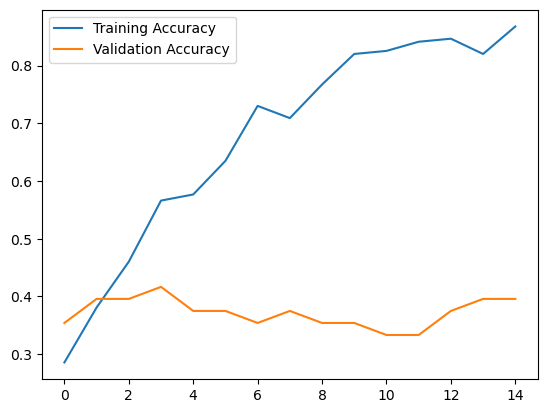

([0.41667], [0.38])

In [7]:
valid_accs = []
test_accs = []

num_epochs=15

cnn = CNN(input_size=X_train_valid_s1.shape[1:], N=n_class).to(device)
valid_acc, trains, valids = fit(cnn, X_train_valid_s1, y_train_valid_s1, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc1, _ = evaluate(cnn, test_dataloader, device)
valid_accs.append(valid_acc)
test_accs.append(test_acc1)

valid_accs, test_accs

### Test relationship between EEGnet single subject validation and test error (Done using Subject 2)

0.17004552278931725
0.09075692855206278


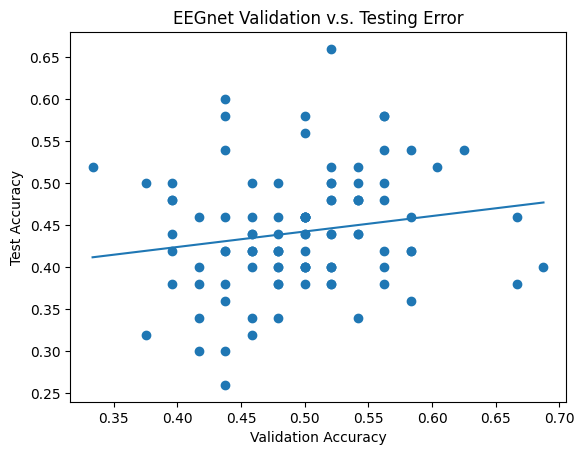

In [ ]:
import scipy

plt.scatter(valid_accs, test_accs)
plt.plot(np.unique(valid_accs), np.poly1d(np.polyfit(valid_accs, test_accs, 1))(np.unique(valid_accs)))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(valid_accs, test_accs)
plt.xlabel("Validation Accuracy")
plt.ylabel("Test Accuracy")
plt.title("EEGnet Validation v.s. Testing Error")
print(r_value)
print(p_value)

## Evaluating Subject 1 Trained network on all other subjects

In [54]:
# Set up data sets

single_subject_testers = []

for subject in range(9):
    
    s1_indices_test = [i for i, s in enumerate(person_test) if s == subject]

    X_test_s1 = X_test[s1_indices_test]
    y_test_s1 = y_test[s1_indices_test]

    # Make dataloader test set for the single subject
    # Convert data to tensors
    X_tensor = torch.FloatTensor(X_test_s1)
    y_tensor = torch.LongTensor(y_test_s1)

    # Combine X and y into a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Prepare dataloaders
    test_dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
    single_subject_testers.append(test_dataloader)

Text(0.5, 1.0, 'Subject 1 Model classifying All Subjects')

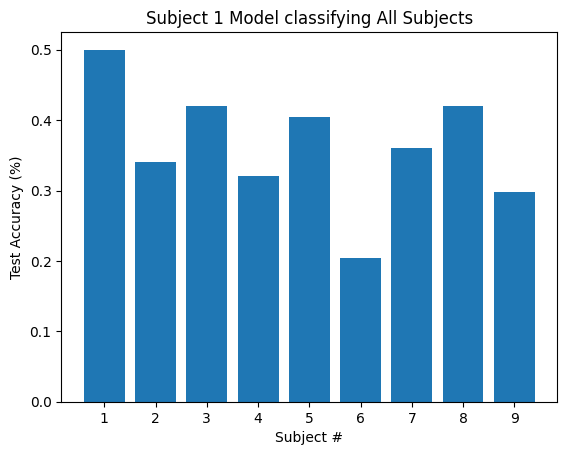

In [50]:
subject_test_acc = []

subject_test_acc.append(test_acc1)

for i in range(8):
    test_acc, _ = evaluate(cnn, single_subject_testers[i+1], device)
    subject_test_acc.append(test_acc)

plt.bar(np.arange(1, 10), subject_test_acc)
plt.xticks(np.arange(1,10))
plt.xlabel("Subject #")
plt.ylabel("Test Accuracy (%)")
plt.title("Subject 1 Model classifying All Subjects")

## RNN (LSTM)

In [7]:
valid_accs = []
test_accs = []

for i in range(n_trials):
    rnn = LSTM().to(device)
    valid_acc = fit(rnn, X_train_valid_s1, y_train_valid_s1, device, epochs=7)
    test_acc, _ = evaluate(rnn, test_dataloader, device)
    valid_accs.append(valid_acc)
    test_accs.append(test_acc)

round(np.mean(valid_accs), 5), round(np.mean(test_accs), 5)

  0%|          | 0/7 [00:00<?, ?it/s]

Best valid accuracy: 0.3125


  0%|          | 0/7 [00:00<?, ?it/s]

Best valid accuracy: 0.27083


  0%|          | 0/7 [00:00<?, ?it/s]

Best valid accuracy: 0.27083


  0%|          | 0/7 [00:00<?, ?it/s]

Best valid accuracy: 0.3125


  0%|          | 0/7 [00:00<?, ?it/s]

Best valid accuracy: 0.35417


(0.30417, 0.224)

## Another RNN (GRU)

GRU takes super long to train, not entirely sure why

I even cut out a fc layer to speed it up, and increase lr

In [8]:
valid_accs = []
test_accs = []

for i in range(n_trials):
    gru = GRU().to(device)
    valid_acc = fit(gru, X_train_valid_s1, y_train_valid_s1, device, epochs=7)
    test_acc, _ = evaluate(gru, test_dataloader, device)
    valid_accs.append(valid_acc)
    test_accs.append(test_acc)

round(np.mean(valid_accs), 5), round(np.mean(test_accs), 5)

  0%|          | 0/7 [00:00<?, ?it/s]

Best valid accuracy: 0.35417


  0%|          | 0/7 [00:00<?, ?it/s]

Best valid accuracy: 0.375


  0%|          | 0/7 [00:00<?, ?it/s]

Best valid accuracy: 0.35417


  0%|          | 0/7 [00:00<?, ?it/s]

Best valid accuracy: 0.29167


  0%|          | 0/7 [00:00<?, ?it/s]

Best valid accuracy: 0.39583


(0.35417, 0.24)

# Parkinson's CRNN

In [9]:
valid_accs = []
test_accs = []

for i in range(n_trials):
    crnn = PD_CRNN(output_size=n_class,).to(device)
    valid_acc = fit(crnn, X_train_valid_s1, y_train_valid_s1, device, epochs=40)
    test_acc, _ = evaluate(crnn, test_dataloader, device)
    valid_accs.append(valid_acc)
    test_accs.append(test_acc)

round(np.mean(valid_accs), 5), round(np.mean(test_accs), 5)

  0%|          | 0/40 [00:00<?, ?it/s]

Best valid accuracy: 0.35417


  0%|          | 0/40 [00:00<?, ?it/s]

Best valid accuracy: 0.33333


  0%|          | 0/40 [00:00<?, ?it/s]

Best valid accuracy: 0.4375


  0%|          | 0/40 [00:00<?, ?it/s]

Best valid accuracy: 0.27083


  0%|          | 0/40 [00:00<?, ?it/s]

Best valid accuracy: 0.4375


(0.36667, 0.248)

## Tonmoy CRNN

In [12]:
valid_accs = []
test_accs = []

for i in range(n_trials):
    crnn2 = HybridCNNLSTM().to(device)
    valid_acc = fit(crnn2, X_train_valid_s1, y_train_valid_s1, device, epochs=100)
    test_acc, _ = evaluate(crnn2, test_dataloader, device)
    valid_accs.append(valid_acc)
    test_accs.append(test_acc)

round(np.mean(valid_accs), 5), round(np.mean(test_accs), 5)

  0%|          | 0/100 [00:00<?, ?it/s]

Best valid accuracy: 0.35417


  0%|          | 0/100 [00:00<?, ?it/s]

Best valid accuracy: 0.45833


  0%|          | 0/100 [00:00<?, ?it/s]

Best valid accuracy: 0.39583


  0%|          | 0/100 [00:00<?, ?it/s]

Best valid accuracy: 0.3125


  0%|          | 0/100 [00:00<?, ?it/s]

Best valid accuracy: 0.5


(0.40417, 0.328)

# Train for all subjects

In [51]:
# Make data loader for all subjects

# Convert data to tensors
X_tensor_full = torch.FloatTensor(X_test)
y_tensor_full = torch.LongTensor(y_test)

# Combine X and y into a TensorDataset
dataset_full = TensorDataset(X_tensor_full, y_tensor_full)

# Prepare dataloaders
test_dataloader_full = DataLoader(dataset_full, batch_size=256, shuffle=False)

## EEGnet (CNN) 

  0%|          | 0/500 [00:00<?, ?it/s]

Best valid accuracy: 0.70213


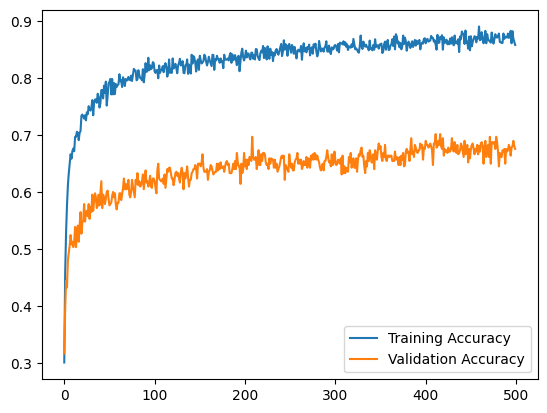

(0.70213, 0.36343)

In [59]:
num_epochs=500

cnn_all = CNN(input_size=X_train_valid.shape[1:], N=n_class).to(device)
valid_acc, trains, valids = fit(cnn_all, X_train_valid, y_train_valid, device, epochs=num_epochs)
plt.figure()
plt.plot(range(num_epochs), trains)
plt.plot(range(num_epochs), valids)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
test_acc, _ = evaluate(cnn, test_dataloader_full, device)

valid_acc, test_acc

## Evaluating All Subject Model on each subject individually:

Text(0.5, 1.0, 'All Subject Model Performance per Subject')

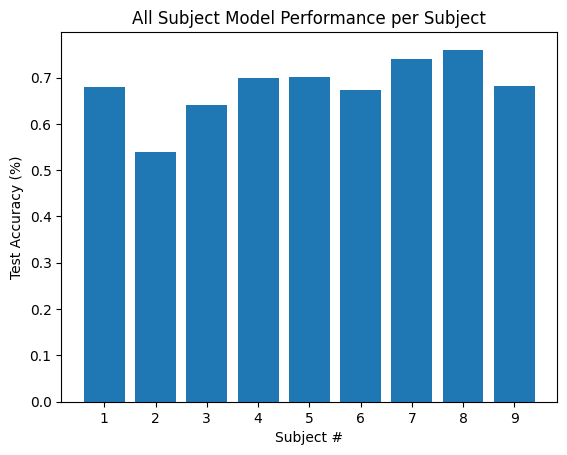

In [61]:
subject_test_acc = []

for i in range(9):
    test_acc, _ = evaluate(cnn_all, single_subject_testers[i], device)
    subject_test_acc.append(test_acc)

plt.bar(np.arange(1, 10), subject_test_acc)
plt.xticks(np.arange(1,10))
plt.xlabel("Subject #")
plt.ylabel("Test Accuracy (%)")
plt.title("All Subject Model Performance per Subject")

## LSTM

  0%|          | 0/50 [00:00<?, ?it/s]

Best valid accuracy: 0.29078


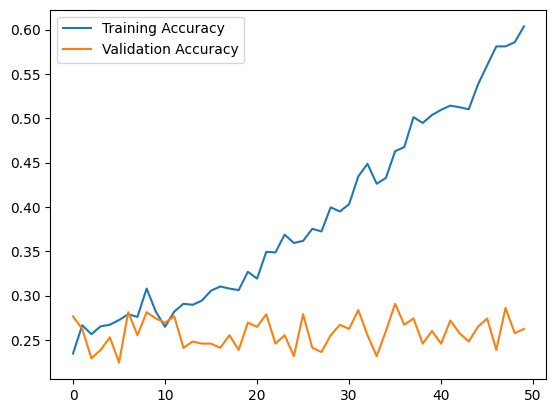

(0.29078, 0.28442)

In [6]:
valid_accs = []
test_accs = []

num_epochs = 50

for i in range(1):
    rnn = LSTM().to(device)
    valid_acc, trains, valids = fit(rnn, X_train_valid, y_train_valid, device, epochs=num_epochs)
    plt.figure()
    plt.plot(range(num_epochs), trains)
    plt.plot(range(num_epochs), valids)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.show()
    test_acc, _ = evaluate(rnn, test_dataloader_full, device)
    valid_accs.append(valid_acc)
    test_accs.append(test_acc)

round(np.mean(valid_accs), 5), round(np.mean(test_accs), 5)

## GRU

In [ ]:
valid_accs = []
test_accs = []

for i in range(n_trials):
    gru = GRU().to(device)
    valid_acc, t, r = fit(gru, X_train_valid, y_train_valid, device, epochs=7)
    test_acc, _ = evaluate(gru, test_dataloader_full, device)
    valid_accs.append(valid_acc)
    test_accs.append(test_acc)

round(np.mean(valid_accs), 5), round(np.mean(test_accs), 5)

## Parkinson's identifying CRNN

  0%|          | 0/50 [00:00<?, ?it/s]

Best valid accuracy: 0.31206


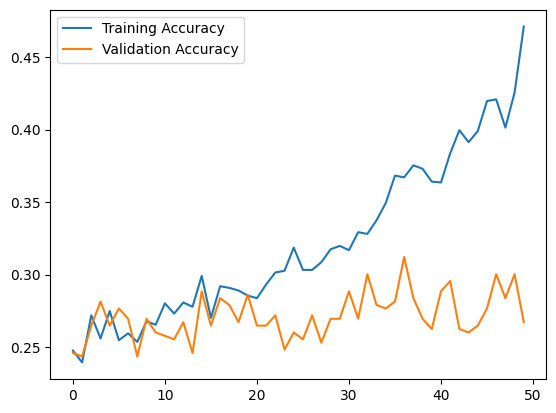

(0.31206, 0.28217)

In [8]:
valid_accs = []
test_accs = []

num_epochs = 50

for i in range(1):
    crnn = PD_CRNN(output_size=n_class,).to(device)
    valid_acc, trains, valids = fit(crnn, X_train_valid, y_train_valid, device, epochs=num_epochs, batch_size=200)
    plt.figure()
    plt.plot(range(num_epochs), trains)
    plt.plot(range(num_epochs), valids)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.show()
    test_acc, _ = evaluate(crnn, test_dataloader_full, device)
    valid_accs.append(valid_acc)
    test_accs.append(test_acc)

round(np.mean(valid_accs), 5), round(np.mean(test_accs), 5)

## Tonmoy CRNN

c:\Python312\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/50 [00:00<?, ?it/s]

Best valid accuracy: 0.38771


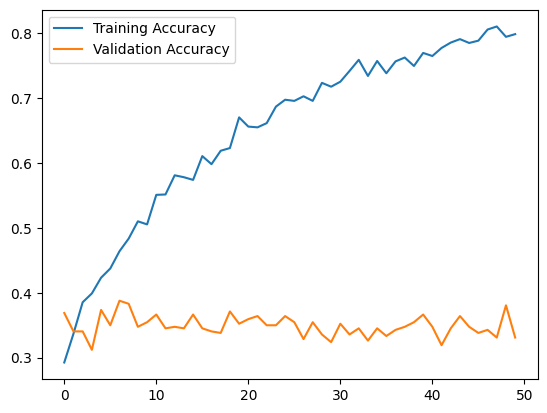

(0.38771, 0.34989)

In [10]:
valid_accs = []
test_accs = []

num_epochs = 50

for i in range(1):
    crnn2 = HybridCNNLSTM().to(device)
    valid_acc, trains, valids = fit(crnn2, X_train_valid, y_train_valid, device, epochs=num_epochs)
    plt.figure()
    plt.plot(range(num_epochs), trains)
    plt.plot(range(num_epochs), valids)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.show()
    test_acc, _ = evaluate(crnn2, test_dataloader_full, device)
    valid_accs.append(valid_acc)
    test_accs.append(test_acc)

round(np.mean(valid_accs), 5), round(np.mean(test_accs), 5)

# Ensemble

Test the effect of ensembling models using max voting

## Lets train a CNN and CRNN, saving the y pred labels

In [16]:
# CNN
y_pred_CNN = []

print("Now training the CNN model\n")
for i in range(5):
    cnn = CNN(input_size=X_train_valid.shape[1:], N=n_class).to(device)
    fit(cnn, X_train_valid, y_train_valid, device, epochs=300)
    _, y_pred = evaluate(cnn, test_dataloader_full, device)
    y_pred_CNN.append(y_pred)

# # RNN (LSTM)
# y_pred_LSTM = []
# print("Now training the LSTM model\n")
# for i in range(n_trials):
#     rnn = LSTM().to(device)
#     fit(rnn, X_train_valid, y_train_valid, device, epochs=1)
#     _, y_pred = evaluate(rnn, test_dataloader_full, device)
#     y_pred_LSTM.append(y_pred)

# # CRNN
# y_pred_CRNN = []

# print("Now training the CRNN model\n")
# for i in range(n_trials):
#     crnn = PD_CRNN(output_size=n_class,).to(device)
#     fit(crnn, X_train_valid, y_train_valid, device, epochs=1)
#     _, y_pred= evaluate(crnn, test_dataloader_full, device)
#     y_pred_CRNN.append(y_pred)

# # CRNN
# y_pred_CRNN_2 = []

# print("Now training the CRNN2 model\n")
# for i in range(n_trials):
#     crnn2 = HybridCNNLSTM().to(device)
#     fit(crnn2, X_train_valid, y_train_valid, device, epochs=1)
#     _, y_pred= evaluate(crnn2, test_dataloader_full, device)
#     y_pred_CRNN_2.append(y_pred)

# Lets try max voting since thats used for classification tasks
def max_voting(*args):
    """
    Perform max voting ensemble for multiple classifiers.
    
    Args:
    *args: Arrays of predicted class labels from each classifier.
    
    Returns:
    Ensemble predictions based on max voting.
    """
    # Concatenate predicted labels along axis 1
    concatenated_predictions = np.concatenate(args, axis=0)
    
    # Find the most frequent prediction for each sample
    ensemble_predictions = np.array([np.argmax(np.bincount(sample_predictions)) for sample_predictions in concatenated_predictions.T])

    return ensemble_predictions

# Now lets try it out
# ensemble_predictions = max_voting(y_pred_CNN, y_pred_LSTM, y_pred_CRNN, y_pred_CRNN_2)
ensemble_predictions = max_voting(y_pred_CNN)

# Get accuracy of ensemble
correct = np.sum(ensemble_predictions == y_test)
total = len(y_test)
accuracy_ensemble = correct/total

print("Accuracy of ensemble: " + str(round(accuracy_ensemble, 5)))

Now training the CNN model



  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.68085


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.73995


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.69504


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.7305


  0%|          | 0/300 [00:00<?, ?it/s]

Best valid accuracy: 0.71158
Accuracy of ensemble: 0.7246


In [14]:
# Output the model architectures
from torchinfo import summary

# EEGNet
EEGnet_summary = CNN(input_size=X_train_valid.shape[1:], N=n_class)
summary(EEGnet_summary, input_size=(64, 22, 1000))

# PD_CRNN
PD_CRNN_summary = PD_CRNN(output_size=n_class)
summary(PD_CRNN_summary, input_size=(64, 22, 1000))



Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 8, 22, 969]          --
│    └─Conv2d: 2-1                       [64, 8, 22, 969]          256
│    └─BatchNorm2d: 2-2                  [64, 8, 22, 969]          16
├─Sequential: 1-2                        [64, 16, 1, 969]          --
│    └─Conv2d: 2-3                       [64, 16, 1, 969]          352
│    └─BatchNorm2d: 2-4                  [64, 16, 1, 969]          32
│    └─ELU: 2-5                          [64, 16, 1, 969]          --
├─AvgPool2d: 1-3                         [64, 16, 1, 484]          --
├─Dropout: 1-4                           [64, 16, 1, 484]          --
├─Sequential: 1-5                        [64, 16, 1, 119]          --
│    └─Conv2d: 2-6                       [64, 16, 1, 477]          2,048
│    └─Conv2d: 2-7                       [64, 16, 1, 477]          256
│    └─Ba

  0%|          | 0/1 [00:00<?, ?it/s]

Best valid accuracy: 0.24823


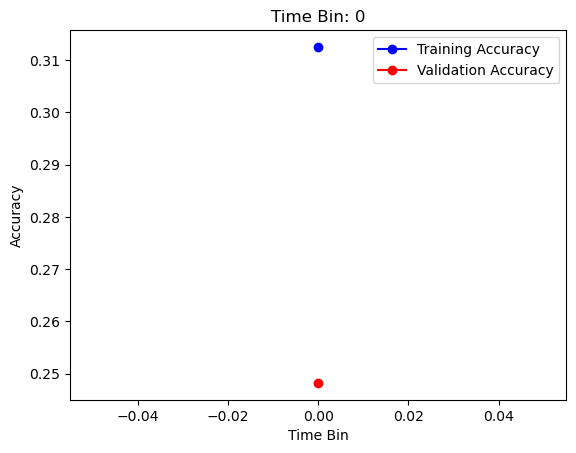

  0%|          | 0/1 [00:00<?, ?it/s]

Best valid accuracy: 0.38771


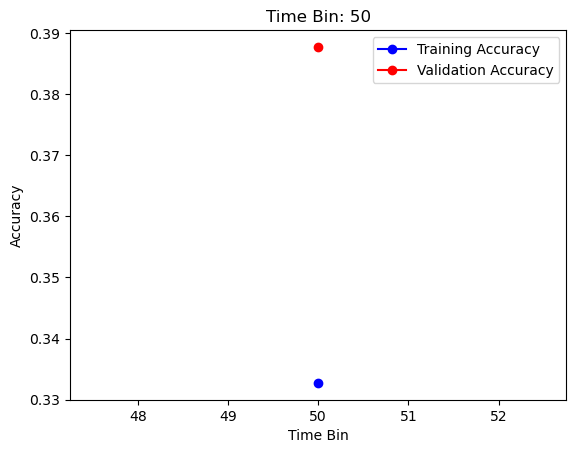

  0%|          | 0/1 [00:00<?, ?it/s]

Best valid accuracy: 0.34043


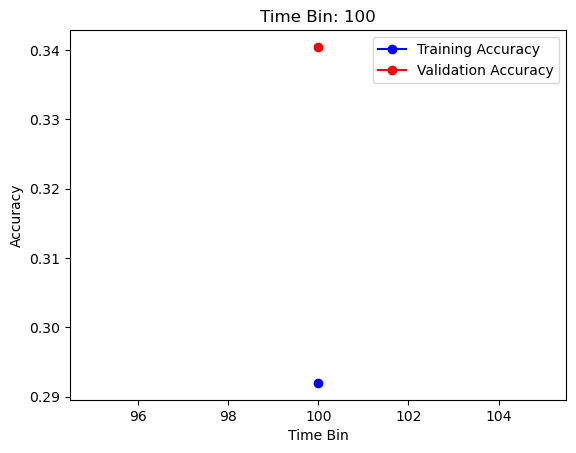

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
# Demo new time_bin parameter for EEGNet

num_epochs = 1
time_bins = range(0, 1000, 50)
train_accs = []
valid_accs = []

for i in time_bins:
    cnn_all = CNN(input_size=X_train_valid.shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_all, X_train_valid, y_train_valid, device, time_bin=i, epochs=num_epochs)
    train_accs.append(trains[0])  # Appending first epoch accuracy
    valid_accs.append(valids[0])  # Appending first epoch accuracy

plt.figure()
plt.plot(time_bins, train_accs, 'bo-', label='Training Accuracy')
plt.plot(time_bins, valid_accs, 'ro-', label='Validation Accuracy')
plt.title("Accuracy for Different Time Bins")
plt.xlabel('Time Bin')
plt.ylabel('Accuracy')
plt.legend()
plt.show()